Replicating: https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb
        
## Multi-label Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [4]:
PATH = "data/planet/"

In [6]:
!ls {PATH}

data  fastai_broke  ReadMe.md


## 2 Multi-Label versus Single-Label Classification

In [7]:
from fastai.plots import *

In [8]:
def get_1st(path): return glob(f'{path}/*.*')[0]

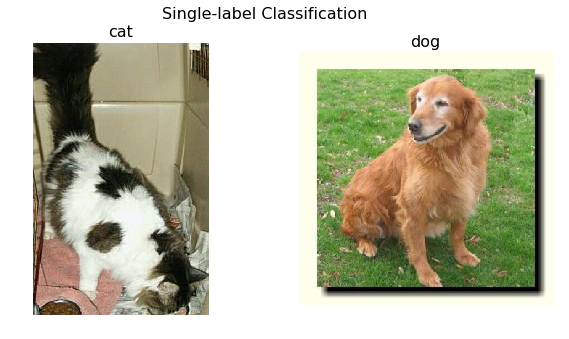

In [10]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label Classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a dog *or* a cat.

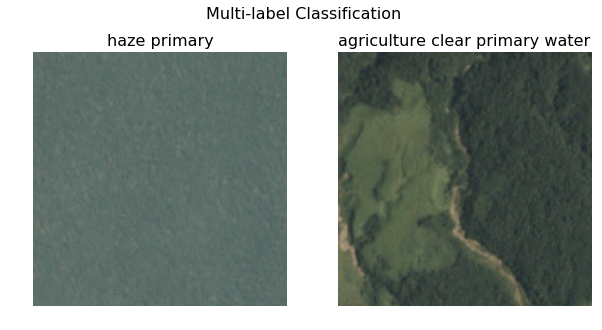

In [12]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles = ["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label Classification")

Softmax wouldn't be good because it wants to "pick *a* thing". Instead, we'll use the Sigmoid. In multi-label clsfn, each sample can belong to one or more classes. In the previous example, the 1st images belong to two classes: *haze* and *primary*. The 2nd belongs to four classes: *agriculture, clear, primary,* and *water*.

## 3 Multi-Label Models for Planet Dataset

fastai is baller AF bc it'll look at the labels in the CSV, and if there're `> 1` labels *ever*, for any item, it'll automatically switch to multi-label mode.

In [43]:
from planet import f2

metrics = [f2]
f_model = resnet34

In [44]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of DAs for this dataset -- we also allow vertical flips, since we don't expect the vertical orientation of satellite images to change our classifications.

In [46]:
def get_data(sz,bs=64):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, bs=bs,
                                        suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [47]:
data = get_data(256) # the planet images are 256x256

In [48]:
# turning a dataloader into an iterator:
x,y = next(iter(data.val_dl)) # note: .._ds: dataset; .._dl: dataloader | PyTorch concepts
# idea: dataset gives you a single image or object back
#       dataloader gives you back a single (transformed) mini-batch (next mini-batch only)

In [49]:
y    # 64x17: batch size x number of classes


    1     0     0  ...      0     1     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.FloatTensor of size 64x17]

In [50]:
# zip, basically zips two lists together into an iterator
list(zip(data.classes, y[0])) # getting the 0th image's labels -- from validation set

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 1.0),
 ('water', 1.0)]

Behind the scenes, FastAI & PyTorch are turning our labels into 1-Hot Encoded Labels.

Storing 1H-Encs as separate arrays is v.inefficient, instead the index values of positive-encodings are used, although the actual 1H-Enc vectors are dealt w/ deep in PyTorch.

In [51]:
data.val_ds.fnames[:15]

array(['train-jpg/train_10.jpg', 'train-jpg/train_10004.jpg', 'train-jpg/train_10007.jpg',
       'train-jpg/train_10010.jpg', 'train-jpg/train_10015.jpg', 'train-jpg/train_10021.jpg',
       'train-jpg/train_10025.jpg', 'train-jpg/train_1004.jpg', 'train-jpg/train_10046.jpg',
       'train-jpg/train_10050.jpg', 'train-jpg/train_10056.jpg', 'train-jpg/train_10057.jpg',
       'train-jpg/train_10063.jpg', 'train-jpg/train_10066.jpg', 'train-jpg/train_10067.jpg'],
      dtype='<U25')

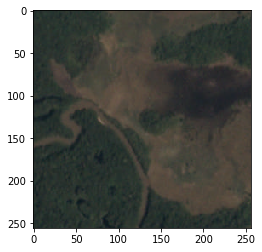

In [63]:
plt.imshow(data.val_ds.get_x(0))

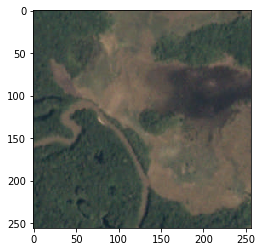

In [64]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);